---
## Word2Vec

The Word2Vec algorithm finds much more efficient representations by finding vectors that represent the words. These vectors also contain semantic information about the words.
Words that show up in similar **contexts**, such as "coffee", "tea", and "water" will have vectors near each other. Different words will be further away from one another, and relationships can be represented by distance in vector space.

---
## Loading Data

Data is loaded from the metadata.csv file provided at the [link](

In [2]:
from google.colab import files
uploaded = files.upload()

Saving metadata2020.csv to metadata2020.csv


In [3]:
import io
file = pd.read_csv(io.BytesIO(uploaded['metadata2020.csv']))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7,14) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
modified_file=file[['sha','title','abstract','pdf_json_files','pmc_json_files']]

In [2]:
#dropping the Nan rows in title and abstract which are of more importance to us

In [6]:
modified_file=modified_file.dropna(subset=['title','abstract'])

## Pre-processing
Done using nltk lemmetiser 
Also removed any html text if present removed stopwords which contribute to noise in the dataset

In [13]:
import nltk
from nltk.corpus import stopwords
nltk.download()
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.stem.porter import *

import re
from bs4 import BeautifulSoup

def review_to_words(review):
    nltk.download("stopwords", quiet=True)
#    stemmer = PorterStemmer()
    
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english") and len(w) > 2] # Remove stopwords
    words = [wordnet_lemmatizer.lemmatize(w) for w in words] # stem
    
    return words

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> l
Packages:
  [ ] abc................. Australian Broadcasting Commission 2006
  [ ] alpino.............. Alpino Dutch Treebank
  [ ] averaged_perceptron_tagger Averaged Perceptron Tagger
  [ ] averaged_perceptron_tagger_ru Averaged Perceptron Tagger (Russian)
  [ ] basque_grammars..... Grammars for Basque
  [ ] biocreative_ppi..... BioCreAtIvE (Critical Assessment of Information
                           Extraction Systems in Biology)
  [ ] bllip_wsj_no_aux.... BLLIP Parser: WSJ Model
  [ ] book_grammars....... Grammars from NLTK Book
  [ ] brown............... Brown Corpus
  [ ] brown_tei........... Brown Corpus (TEI XML Version)
  [ ] cess_cat............ CESS-CAT Treebank
  [

In [14]:
modified_file_small=modified_file.sample(frac=0.1,replace=False)

In [1]:
#As computation took a longer time just expermiented with 10 percent of the data(cleaned)

In [15]:
abstract_words=[]

In [16]:
for file in modified_file_small['abstract']:
    word=[]
    word=review_to_words(file)
    abstract_words.append(word)

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:273: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


In [17]:
words=sum(abstract_words,[])

In [3]:
#thus words is now a list of all words present in the abstracts of the data which we have chosen

In [23]:
import re
from collections import Counter

def preprocess(text):

    # Replace punctuation with tokens so we can use them in our model
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <COMMA> ')
    text = text.replace('"', ' <QUOTATION_MARK> ')
    text = text.replace(';', ' <SEMICOLON> ')
    text = text.replace('!', ' <EXCLAMATION_MARK> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    text = text.replace('(', ' <LEFT_PAREN> ')
    text = text.replace(')', ' <RIGHT_PAREN> ')
    text = text.replace('--', ' <HYPHENS> ')
    text = text.replace('?', ' <QUESTION_MARK> ')
    # text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <COLON> ')
    words = text.split()
    
    # Remove all words with  5 or fewer occurences
    word_counts = Counter(words)
    trimmed_words = [word for word in words if word_counts[word] > 5]

    return trimmed_words


def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab



In [4]:
#though punctutations werent required in the preprocess function coz they have already been removed earlier bt 
#it could be used when the nltk method isnt used ie when words like is are in of are of some importance in text prediction

In [24]:
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 945063
Unique words: 38543


### Dictionaries

Next,creating two dictionaries to convert words to integers and back again (integers to words). `create_lookup_tables` takes in a list of words in a text and returns two dictionaries.
>* The integers are assigned in descending frequency order, so the most frequent word ("the") is given the integer 0 and the next most frequent is 1, and so on. 

Once we have our dictionaries, the words are converted to integers and stored in the list `int_words`.

In [26]:
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

print(int_words[:30])

[0, 1135, 86, 256, 19, 28, 2651, 55, 1825, 1596, 56, 8, 743, 1363, 1966, 18, 1731, 2651, 632, 965, 2212, 1794, 1862, 923, 459, 8437, 23, 45, 25, 72]


## Subsampling

Words that show up often such as "the", "of", and "for" don't provide much context to the nearby words. If we discard some of them, we can remove some of the noise from our data and in return get faster training and better representations. For each word $w_i$ in the training set, we'll discard it with probability given by 
Here such words arent present bt the most occuring words like cov,sars could be discarded as they dont enrich our dataset

In [27]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[86, 19, 2651, 8, 965, 1862, 459, 8437, 25, 3666, 2213, 750, 4702, 2651, 2651, 9126, 6043, 2651, 17761, 7394, 2814, 219, 803, 17762, 2214, 17763, 1559, 256, 1093, 18]


## Making batches

With the skip-gram architecture, for each word in the text, we want to define a surrounding _context_ and grab all the words in a window around that word, with size $C$. 

"Since the more distant words are usually less related to the current word than those close to it, we give less weight to the distant words by sampling less from those words in our training examples... If we choose $C = 5$, for each training word we will select randomly a number $R$ in range $[ 1: C ]$, and then use $R$ words from history and $R$ words from the future of the current word as correct labels."

In [28]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [29]:
# testing purpose

# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [0, 1, 2, 3, 4, 6, 7, 8, 9]


### Generating Batches 

Here's a generator function that returns batches of input and target data for our model, using the `get_target` function from above. The idea is that it grabs `batch_size` words from a words list. Then for each of those batches, it gets the target words in a window.

In [30]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches so discarding the remaingi words 
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]#getting each batch
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [31]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 0, 2, 3, 0, 1, 3, 0, 1, 2]


## Building the graph

Below is an approximate diagram of the general structure of our network.
<img src="assets/skip_gram_arch.png" width=60%>

>* The input words are passed in as batches of input word tokens. 
* This will go into a hidden layer of linear units (our embedding layer). 
* Then, finally into a softmax output layer. 

We'll use the softmax layer to make a prediction about the context words by sampling, as usual.

The idea here is to train the embedding layer weight matrix to find efficient representations for our words. We can discard the softmax layer because we don't really care about making predictions with this network. We just want the embedding matrix so we can use it in _other_ networks we build using this dataset.

---
## Validation

Here, I'm creating a function that will help us observe our model as it learns. We're going to choose a few common words and few uncommon words. Then, we'll print out the closest words to them using the cosine similarity: 

<img src="assets/two_vectors.png" width=30%>

$$
\mathrm{similarity} = \cos(\theta) = \frac{\vec{a} \cdot \vec{b}}{|\vec{a}||\vec{b}|}
$$


We can encode the validation words as vectors $\vec{a}$ using the embedding table, then calculate the similarity with each word vector $\vec{b}$ in the embedding table. With the similarities, we can print out the validation words and words in our embedding table semantically similar to those words. It's a nice way to check that our embedding table is grouping together words with similar semantic meanings.

In [32]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

## SkipGram model
 defined an [embedding layer]and a final, softmax output layer.

An Embedding layer takes in a number of inputs, importantly:
* **num_embeddings** – the size of the dictionary of embeddings, or how many rows you'll want in the embedding weight matrix
* **embedding_dim** – the size of each embedding vector; the embedding dimension

In [33]:
import torch
from torch import nn
import torch.optim as optim

In [34]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

### Training

Below is our training loop, and I recommend that you train on GPU, if available.

**Note that, because we applied a softmax function to our model output, we are using NLLLoss** as opposed to cross entropy. This is because Softmax  in combination with NLLLoss = CrossEntropy loss .

In [35]:
evice = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
evice

'cuda'

In [48]:
# check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=50 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 400
steps = 0
epochs = 5

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

one | resonant, ornithobacterium, reformation, minion, nsp12
impact | intoxicated, hsv1, expects, repatriated, adaboost
including | velogenic, calprotectin, pfos, onward, endoderm
disease | 2050, narrowing, deepfaked, tnbc, limitation
spread | trickle, tkr, hpas, deadliest, borides
however | sengkang, subnets, italian, thrombophilia, imipenem
syndrome | particularly, abstraction, abolished, contradiction, ropositifs
compared | aspires, dnn, correlational, otolaryngologic, beard
antibiotic | pand, dst, disinformation, neuroticism, clonal
processing | rhinosinusitis, inmediato, membres, traversed, ucc
contribution | 108, cd107a, tiologie, parler, medrxiv
contrast | managing, rop, phenomenon, agr, testicular
living | tense, fsi, ischemia, documentary, decentralized
certain | gvp, hemorrhoid, fryling, 848, isatis
de | thioredoxin, behaves, s100a4, triptolide, routinely
density | assumption, graduate, provisional, qnc, adequate
...
one | resonant, reformation, minion, daughter, nsp12
virus 

## Visualizing the word vectors

Below we'll use T-SNE to visualize how our high-dimensional word vectors cluster together. T-SNE is used to project these vectors into two dimensions while preserving local stucture.

In [49]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [50]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()

In [51]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

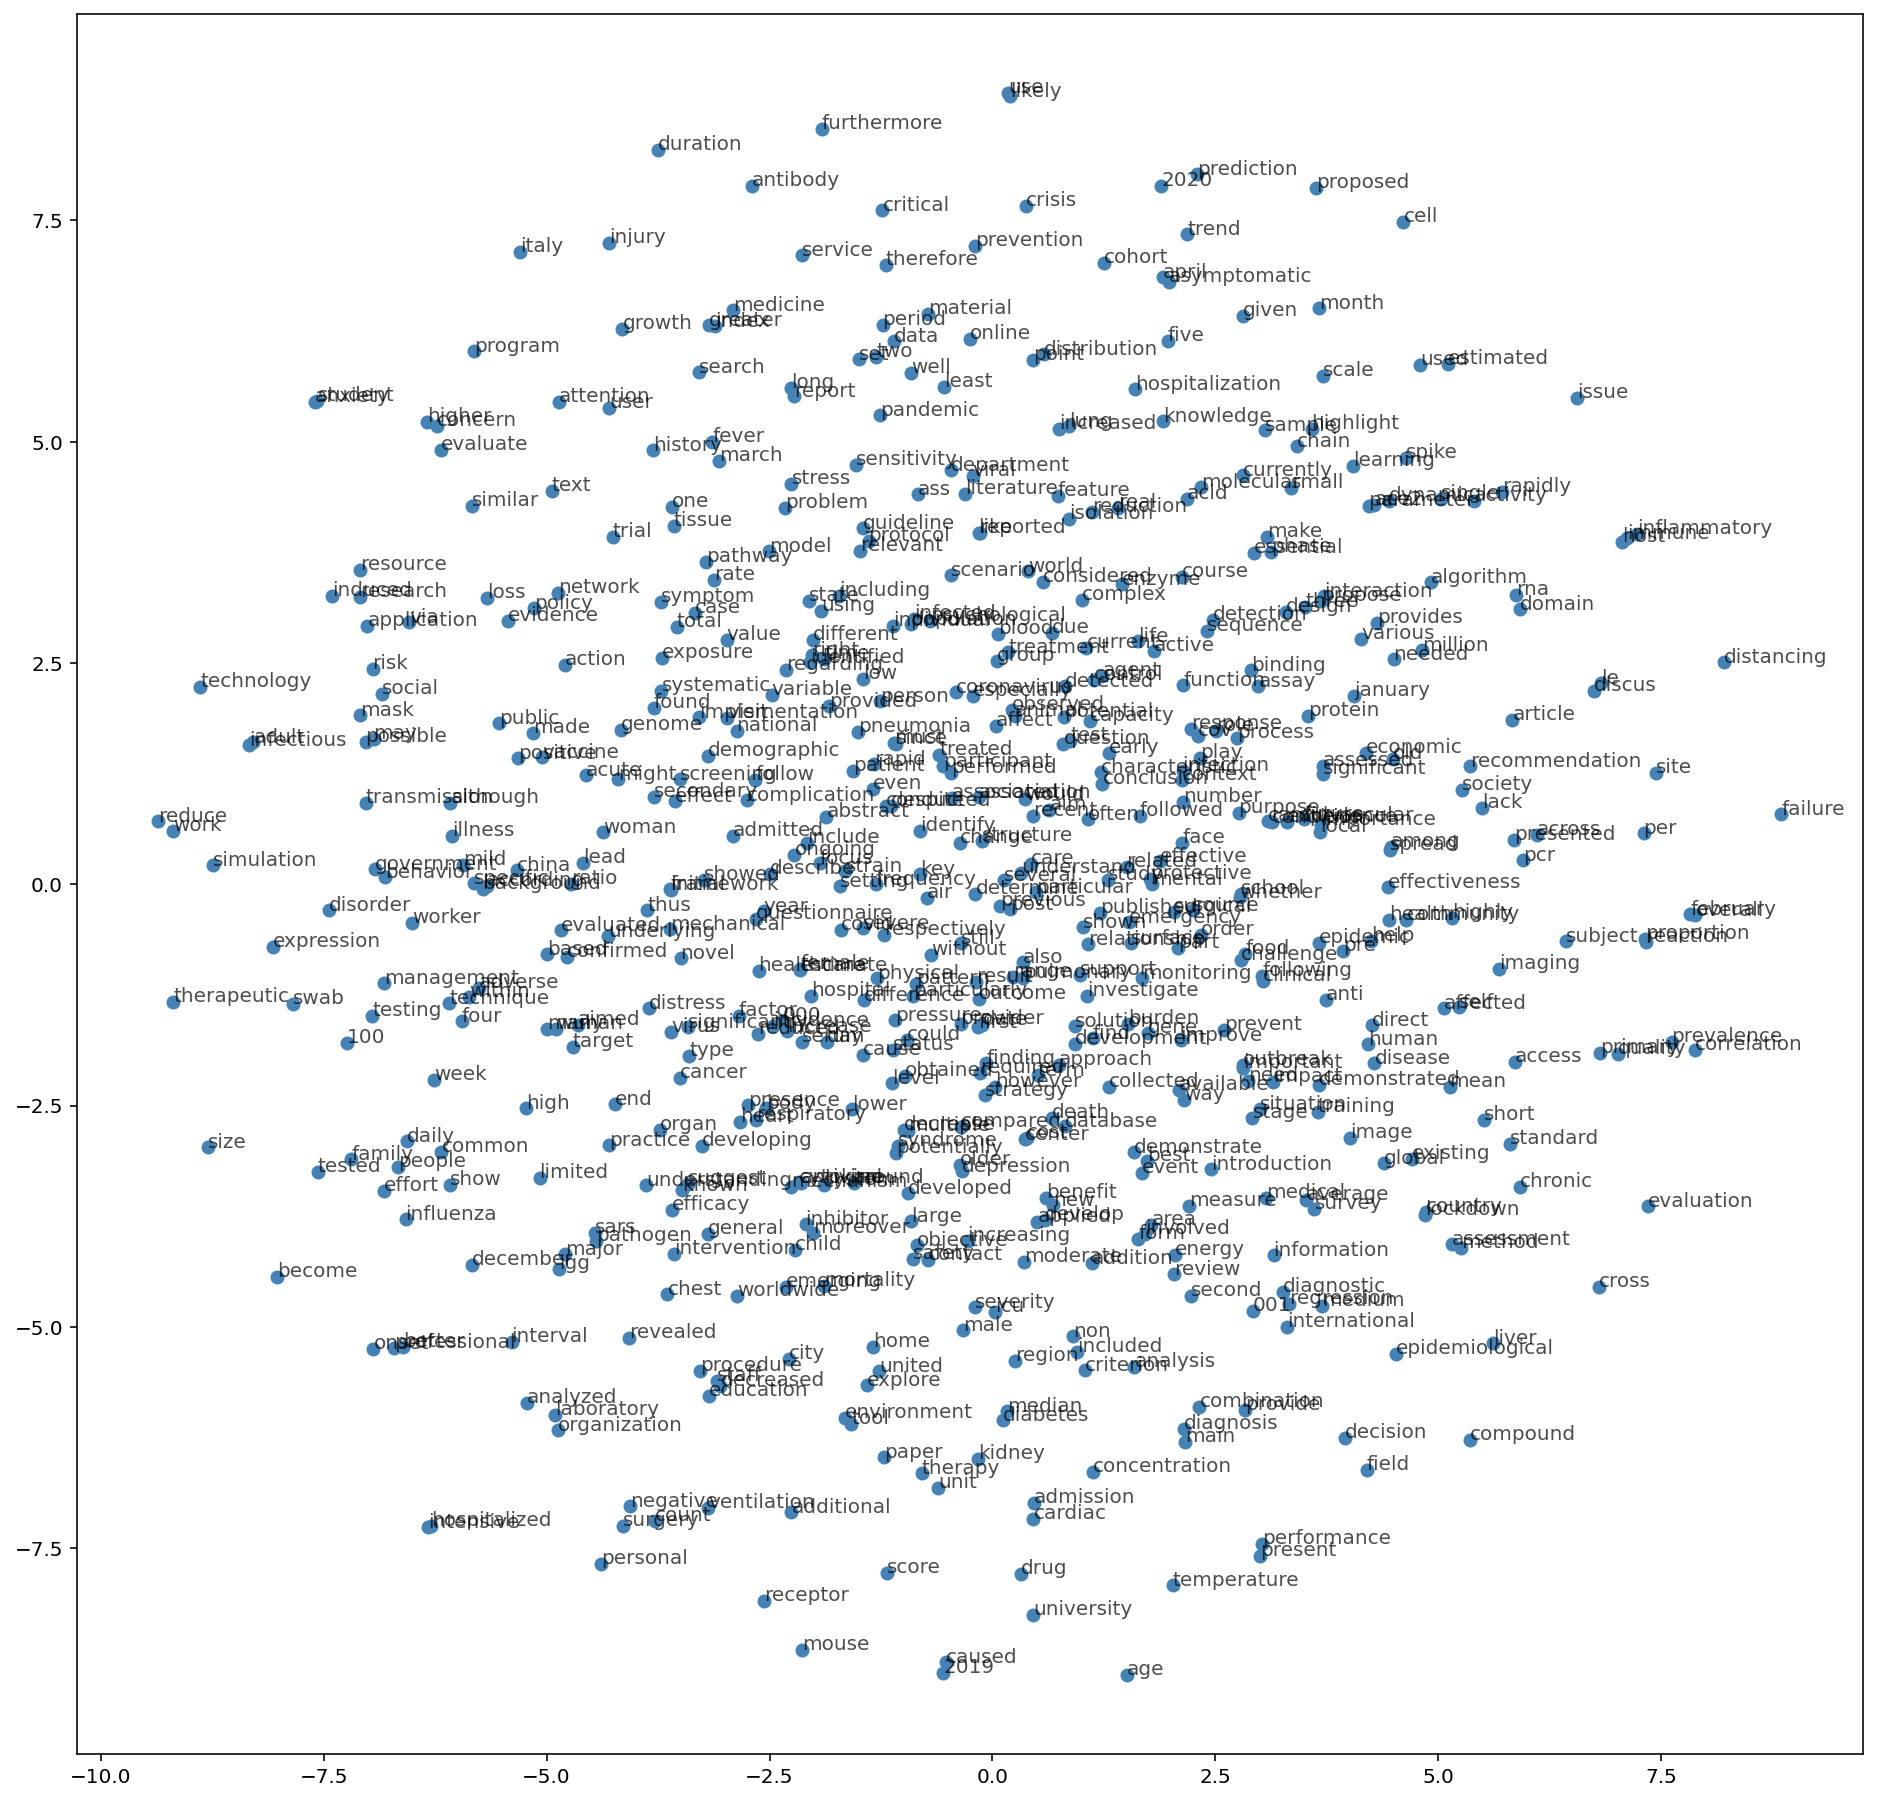

In [52]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [6]:
#Notable findings

In [5]:
# virus | versatility, lipoxygenase, icam, spurious, target
# peptide | aerographic, hertz, candy, jury, cafd
# absence | reporting, preferred, macc1, mechanism, nutritious
# present | login, trafficked, commuter, causing, salary
# antibiotic | hyperglycemic, salimalii, antifeedant, repositioning, master

In [53]:
viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

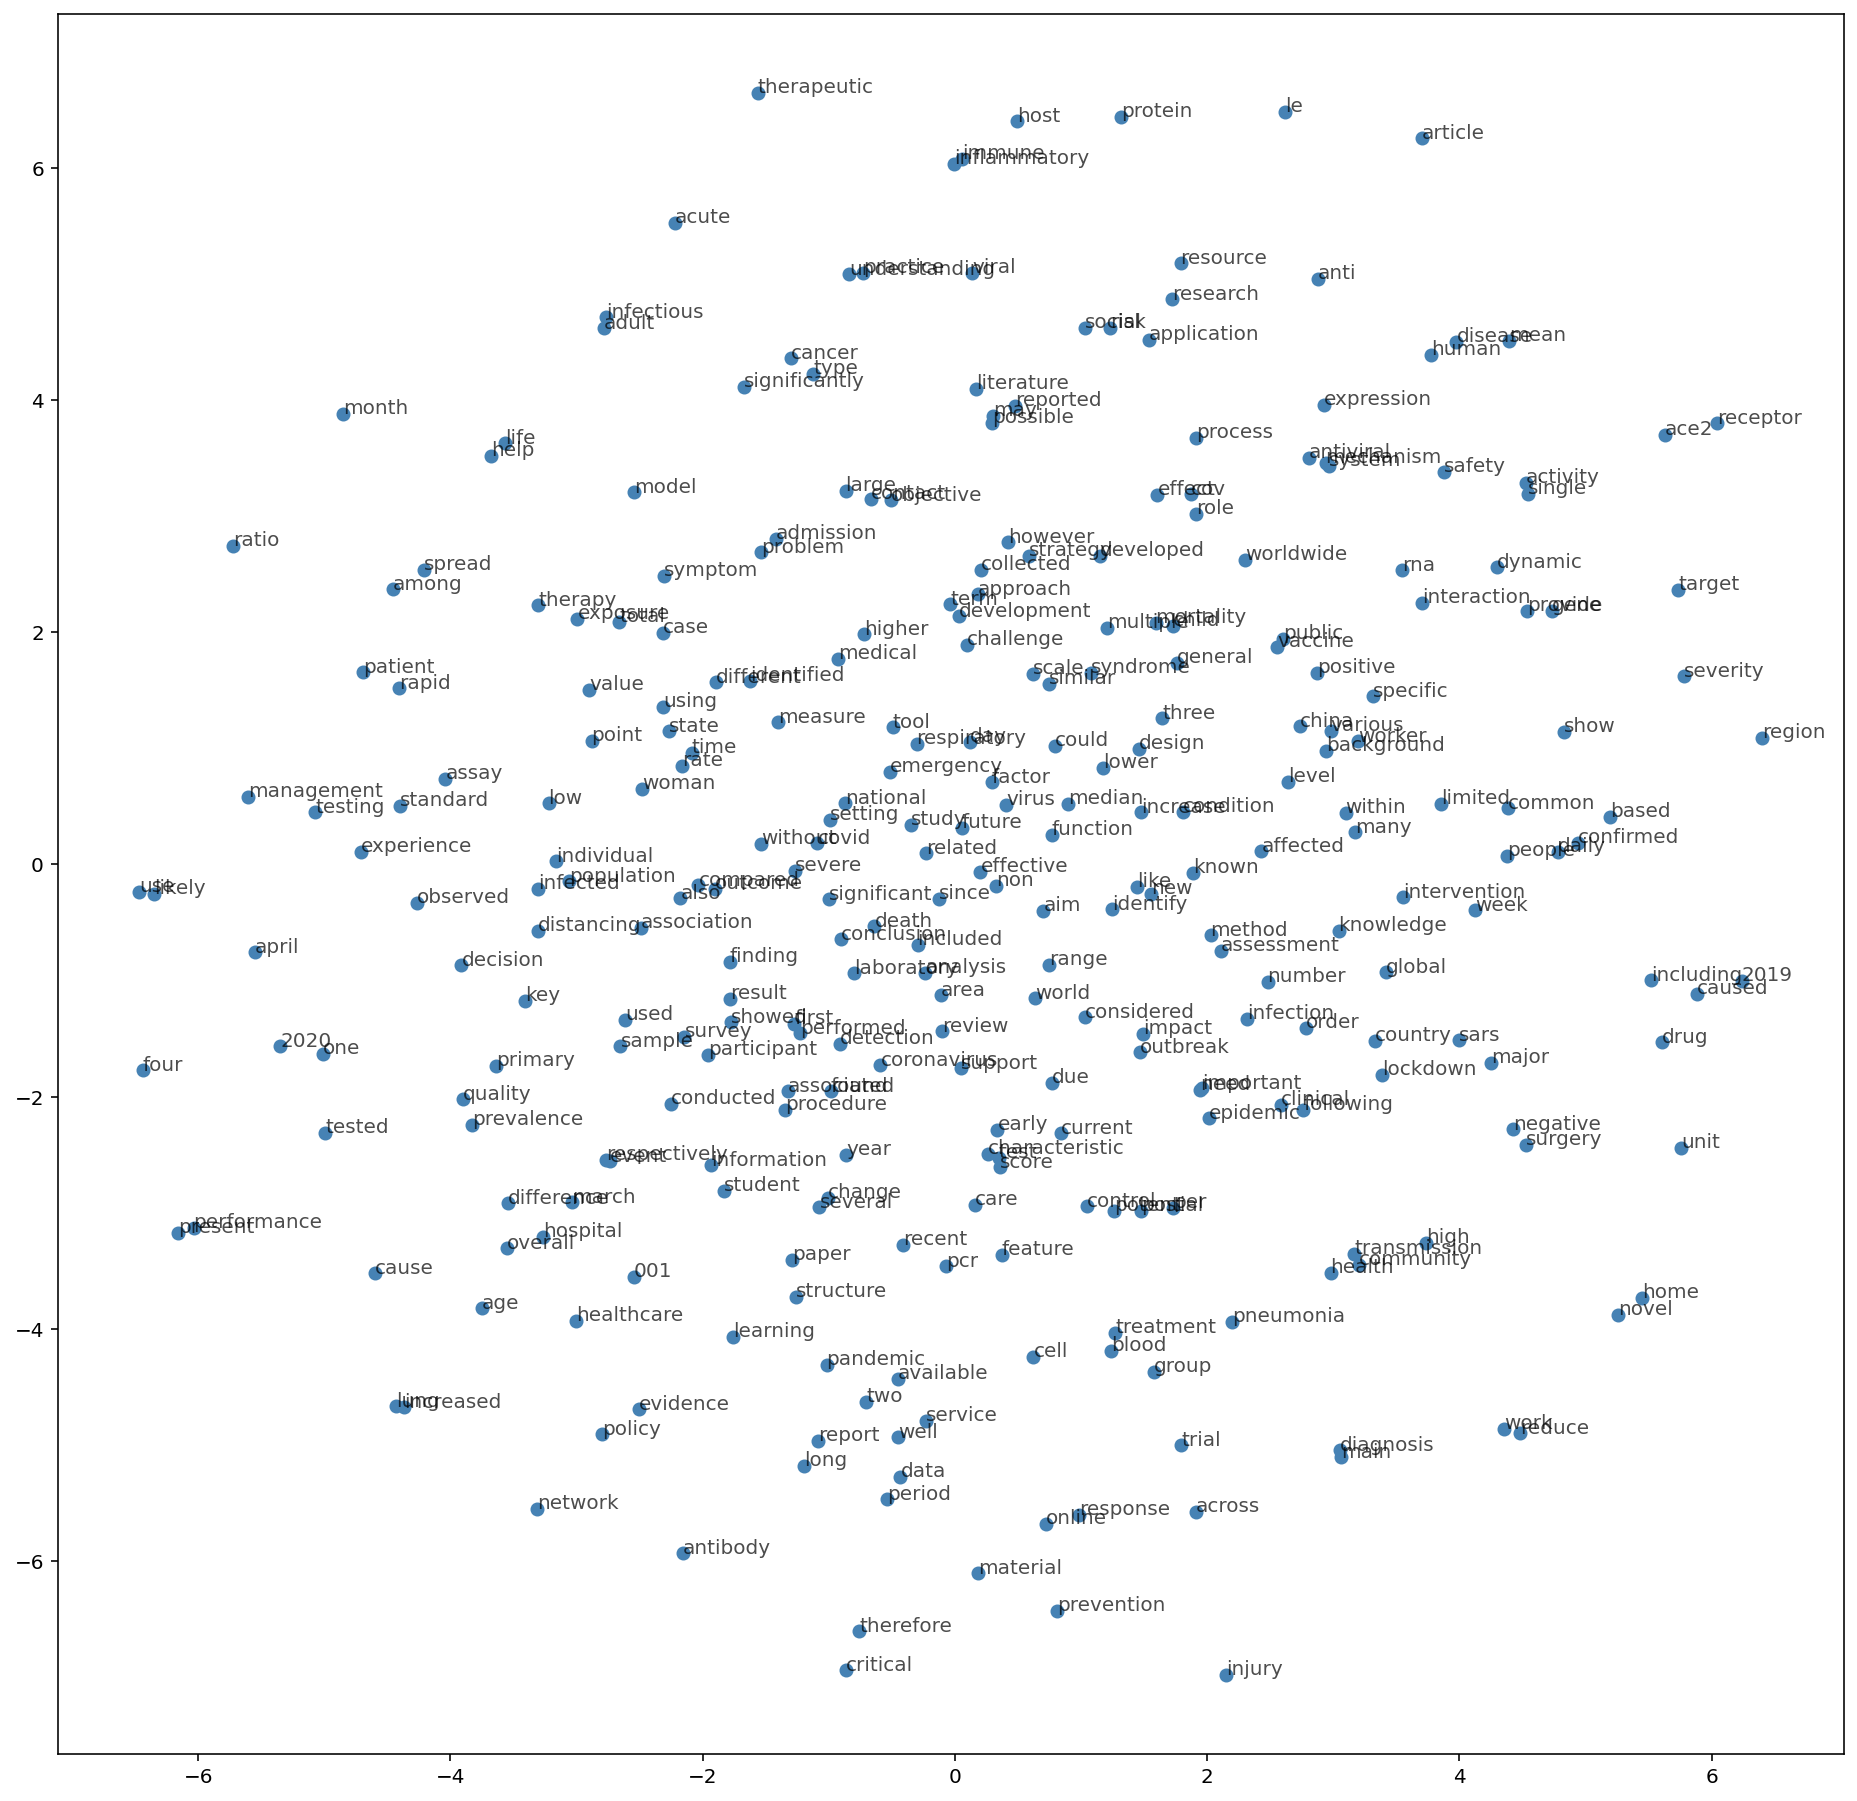

In [54]:
fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

In [1]:
############################################

In [ ]:
#for embedding_dim=500,print_every=4 we get the follwing 

In [ ]:
based | lpp, gly, feasibility, taskforce, reassuring
social | islamic, overhauled, consolidated, kdm5b, postsecondary
individual | transmittance, histopathological, 611, budapest, guanyl
use | mathematician, nct04308668, tweetable, debated, 989
day | suspected, rotators, mildest, practicality, sin
may | climatic, neutropenia, alarmingly, harmonic, perez
epidemic | chimere, aice, basin, sle, recommended
respiratory | venue, particulate, sorbonne, hcwh, catered
operation | negative, bame, pratiques, challenge, cml
sensitive | coronaviridiae, dependent, correlated, invention, informatis
successful | refill, identificar, souffrant, hyperglycemic, maod
difficult | disturbed, 265, representan, export, extrapolated
scan | wilcoxcon, kutupalong, audio, interconnect, washed
guide | muscular, heilongjiang, restructured, agnps, hcw
every | 1595, siege, lebanon, sd2, fragilis
isolated | contract, n95, orl, tag, epigenetic
...
use | mathematician, nct04308668, 989, bachelor, tweetable
syndrome | larva, 02357, nirs, nitric, neuraxial
death | etching, piece, waiver, visit, ssf
research | ast, adjust, scarcity, exact, 1203
individual | transmittance, origin, 611, guanyl, histopathological
approach | urologist, heeded, 1800, rmsre, 405
finding | heparinised, sphere, export, e138, databank
may | climatic, alarmingly, neutropenia, perez, decree
availability | disfunction, link, eingehen, actigraphic, tma
grade | bioavailable, 990, sophisticated, spectroscopy, wallis
contrast | desert, metabolically, catalytically, proteasome, proofread
error | blended, ultrasonic, option, sanitizers, confront
continue | trouble, 2006, 02142, polyuridine, scaif
industry | eventually, buttressed, coerced, actrec, eeis
droplet | 492, toxicogenomic, diabzi, harmonize, shiftwork
sector | complementarity, ensuite, ifabp, smape, chapter
...
individual | transmittance, guanyl, origin, komfo, 611
higher | neuropathologic, 001, restaging, lazio, azocasein
health | sbt, noncore, number, envelop, atp
group | instrumentation, wbc, traveler, psychopathologic, phenolphthalein
new | thermophoresis, beta, imprinted, trek, emptiness
outcome | banishment, randomisation, 100, peace, swb
method | fluroquinolones, star, sequencer, hyperintensity, immunofluorescence
background | absent, ifng, everyday, vestibular, measurable
frequent | measles, poultry, perniosis, sunda, 184
grade | bioavailable, 990, sophisticated, wallis, ignores
protected | ppa, subyearling, perpetually, phagocytosed, lactococcus
de | alaska, practically, covered, ampe, ndete
interview | materiomusic, efs, neural, tjc, 104
registration | informationization, outburst, lazio, 204, 1953
consultation | displacement, knight, preventative, tetanic, fam
continue | trouble, 2006, atop, 02142, polyuridine
...
transmission | 919, titanium, ordering, vesicular, mmpta
analysis | valuable, device, photocatalyzed, cortrosyn, enabled
risk | bell, amidobenzimidazole, mechanised, 123, seldomly
among | agr1, admission, dnar, countering, streamed
population | nsted, carcinogenic, putorius, nanoluciferase, bark
present | causing, login, trafficked, commuter, salary
individual | transmittance, guanyl, origin, budapest, 611
2019 | salient, crf3, rheumatic, hyperobject, vertical
guide | muscular, heilongjiang, hcw, row, advisable
call | religious, fructooligosaccharides, mathematician, investing, 030
mobility | cosmological, rey, alone, cervix, overburden
extracted | investing, populous, outlining, 7989, handicap
sector | complementarity, smape, ifabp, ensuite, eagerly
diverse | period2006, ctds, barrier, geraniol, ipld
contribution | youden, relaciona, thc, seculae, lincluding
indicator | dong, smart, cyp3a4, neuroexocytotic, quences
...
age | spermatozoon, gopalan, 876, grumbach, nct03609385
potential | vivadiag, contribute, megena, procion, pgy
including | honorable, 7nachr, wheezing, 238, subspecialist
present | login, trafficked, commuter, causing, salary
year | sucrose, niveau, goertzel, pod1, 04301
virus | lipoxygenase, versatility, spurious, icam, valsalva
population | nsted, carcinogenic, putorius, twd, nanoluciferase
care | deliverance, dehydration, anticonvulsant, ineligible, thumb
upon | reactivations, paraphernalia, csdmards, solanum, pccf
availability | disfunction, actigraphic, link, sarsen, eingehen
considering | nct04343729, intensifying, phenoage, discharging, banning
antibiotic | hyperglycemic, salimalii, antifeedant, repositioning, master
tomography | ghosh, retrograde, 20x, pericarpium, mda
nucleic | communicative, normalcy, sias, 3881, killing
allows | flat, maske, fprs, ultrafine, 50z
indicator | dong, smart, quences, cyp3a4, 19th
...
background | absent, prospectivo, everyday, khartoum, vestibular
country | premier, km2, reinitiate, ortmans, lacked
coronavirus | designer, gamification, initiate, 1918, ceiling
potential | vivadiag, megena, contribute, dezember, pgy
impact | fuel, bell, tospoviridae, demography, fomite
rate | sio2, challenged, planar, locomotion, sed
using | landmark, lymph, anxious, quiz, encompassed
virus | versatility, lipoxygenase, icam, spurious, target
peptide | aerographic, hertz, candy, jury, cafd
academic | bzw, magnetic, spasm, medicaid, htai
calculated | disparity, deer, earliness, combined, depletion
absence | reporting, preferred, macc1, mechanism, nutritious
suggesting | dopaminergic, proteoglycan, covccf, tailored, orchid
every | 1595, siege, lebanon, rendering, piritramide
mobility | rey, cosmological, alone, oppositely, albicans
extracted | investing, populous, 7989, outlining, covid3d
...

In [2]:
#the tsne plots for the same are as follows

In [4]:
#for viz_words=600

---

<img src="assets/tsne_500.1.png" width=100%>



In [5]:
#For viz_words=300

---

<img src="assets/tsne_500.2.png" width=100%>

